In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers.legacy import Adam

In [134]:
model = tf.keras.models.load_model("./unet_models/epochs60.h5")

In [121]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [122]:
x = np.ones((2894, 128, 128))
x_val = np.load("processed_data/val/seismic.npy")
y_val = np.load("processed_data/val/annotation.npy")

In [123]:
x.shape

(2894, 128, 128)

In [135]:
i = 22
large_image_scaled = x_val[i]
large_image_scaled = np.expand_dims(large_image_scaled, axis=2)
# large_image_scaled = np.reshape(x_val[i],(x_val[i].shape[0],x_val[0].shape[1],1))
large_image_scaled.shape

(512, 512, 1)

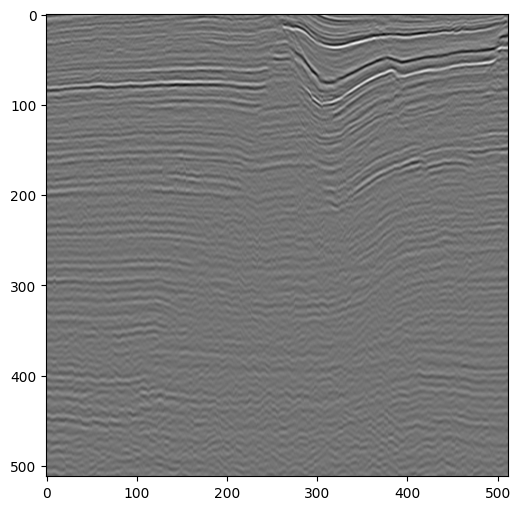

In [136]:
plt.figure(figsize = (8,6))
plt.imshow(large_image_scaled,"gray")
plt.show()

In [137]:
import time
#only works for square matrix
ti =time.time()
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    if pad_width[1] != 0:           
        vector[-pad_width[1]:] = pad_value
        
def process_image_for_prediction(model,image_train,image_val):
    #process bigger images(x_val dims) for prediction by dividing bigger image into smaller parts(according to x_train dims) and collasing
    #back to original
    
    x_train_dim, y_train_dim = image_train.shape
    x_val_dim, y_val_dim = image_val.shape
    
    print(x_train_dim, x_val_dim, "x_train_dim, x_val_dim")
    
    print(x_val_dim % x_train_dim, "mod")
    if(x_val_dim % x_train_dim):
        # not divisible need to padd with zeros
        no_of_spaces_needed = x_val_dim % x_train_dim
        print(no_of_spaces_needed,'no_of_spaces_needed')
        image_val = np.pad(image_val,((0,1),(0,1)),pad_with,padder = 0) # top =0, down= 1, left =0, right =1 padding
        
        # update the x_val_dim, y_val_dim as it was updated with padding
        x_val_dim, y_val_dim = image_val.shape
        print(x_val_dim, y_val_dim, 'x_val_dim, y_val_dim updated')
    
    
    #iterate all the smaller parts and predict each of them
    no_of_parts = x_val_dim / x_train_dim # since it is square, y will be same
    print(no_of_parts, "no_of_parts")

    predicted_matrix = np.zeros((x_val_dim,y_val_dim,1))

    for i in range(0,int(no_of_parts)):
        for j in range(0,int(no_of_parts)):
            part_image = image_val[i*x_train_dim:(i+1)*x_train_dim,j*y_train_dim:(j+1)*y_train_dim]
            part_image = np.reshape(part_image,(part_image.shape[0],part_image.shape[1],1))
            part_image = tf.expand_dims(part_image,axis=0)
            print(part_image.shape, 'part_image_shape')
            predicted_matrix[i*x_train_dim:(i+1)*x_train_dim, j*y_train_dim:(j+1)*y_train_dim]  = model.predict(part_image)
            print(predicted_matrix.shape,'predicted_matrix_shape')
    
    return predicted_matrix
print(time.time()-ti, "seconds to predict")

0.001077890396118164 seconds to predict


In [138]:
processed_prediction = process_image_for_prediction(model,x[0],x_val[i])

128 512 x_train_dim, x_val_dim
0 mod
4.0 no_of_parts
(1, 128, 128, 1) part_image_shape


2023-03-30 17:51:32.032860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 365ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 24ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 19ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 20ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 20ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 21ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 20ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==============================] - 0s 22ms/step
(512, 512, 1) predicted_matrix_shape
(1, 128, 128, 1) part_image_shape
1/1 [==========

In [139]:
def pad_with(vector, pad_width, iaxis,kwargs):
    pad_value = kwargs.get('padder',0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def smooth_prediction(model,strides,to_pred_img,orig_img): # orig_img = the image where the model is been trained, to_pred_img = the bigger section img wheren we are trying to predict
    orig_h,orig_w = orig_img.shape
    pred_img_h, pred_img_w = to_pred_img.shape
    pred_padded_img = np.pad(to_pred_img,orig_h,pad_with)
    print(pred_padded_img)
    no_of_parts_h = np.ceil((pred_padded_img.shape[0]-(orig_h-1))/strides)
    no_of_parts_w = np.ceil((pred_padded_img.shape[1]-(orig_w-1))/strides)
    print(no_of_parts_h,'no_of_parts')
    sum_predicted_img = np.zeros((pred_padded_img.shape[0],pred_padded_img.shape[1],1))
    print(sum_predicted_img.shape)
    print((sum_predicted_img[orig_h:(sum_predicted_img.shape[0]-orig_h),orig_w:(sum_predicted_img.shape[1]-orig_w)]).shape)
    
    for i in range(0,int(no_of_parts_h)):
        for j in range(0,int(no_of_parts_w)):
            part_image = pred_padded_img[i*strides:(i*strides+orig_h),j*strides:(j*strides+orig_w)]
            part_image = np.reshape(part_image,(part_image.shape[0],part_image.shape[1],1))
            part_image = tf.expand_dims(part_image,axis=0)
            # print(i*strides,i*strides+orig_h,j*strides,j*strides+orig_w,"yeah")
            # print(part_image.shape, 'part_image_shape')
            val = model.predict(part_image)
            # print(val.shape,'val',(sum_predicted_img[i*strides:(i*strides+orig_h),j*strides:(j*strides+orig_w)]).shape,'cutted_shape')
            sum_predicted_img[i*strides:(i*strides+orig_h),j*strides:(j*strides+orig_w)]+=val[0]
            # print(sum_predicted_img.shape,'predicted_matrix_shape')
            
    return (sum_predicted_img[orig_h-1:(sum_predicted_img.shape[0]-orig_h),orig_w-1:(sum_predicted_img.shape[1]-orig_w)])/no_of_parts_h
    
    
    

In [140]:
import time
t = time.time()
padded_smooth_prediction = smooth_prediction(model,30,x_val[i],x[0])
print(time.time()-t,"seconds took to predict")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
22.0 no_of_parts
(768, 768, 1)
(512, 512, 1)
1/1 [==============================] - 0s 19ms/step
32.04244923591614 seconds took to predict


In [142]:
patch_size=128
n_classes=1

In [143]:
predictions_smooth = predict_img_with_smooth_windowing(
    large_image_scaled,    #Must be of shape (x, y, c) --> NOT of the shape (n, x, y, c)
    window_size=patch_size,
    subdivisions=4,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

  0%|                                                                          | 0/8 [00:00<?, ?it/s]2023-03-30 17:52:10.583538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 9s 349ms/step


 12%|████████▎                                                         | 1/8 [00:10<01:11, 10.28s/it]

27/27 [==============================] - 9s 329ms/step


 25%|████████████████▌                                                 | 2/8 [00:19<00:58,  9.78s/it]

27/27 [==============================] - 9s 331ms/step


 38%|████████████████████████▊                                         | 3/8 [00:29<00:48,  9.64s/it]

27/27 [==============================] - 9s 332ms/step


 50%|█████████████████████████████████                                 | 4/8 [00:38<00:38,  9.58s/it]

27/27 [==============================] - 9s 331ms/step


 62%|█████████████████████████████████████████▎                        | 5/8 [00:48<00:28,  9.54s/it]

27/27 [==============================] - 9s 332ms/step


 75%|█████████████████████████████████████████████████▌                | 6/8 [00:57<00:19,  9.53s/it]

27/27 [==============================] - 9s 333ms/step


 88%|█████████████████████████████████████████████████████████▊        | 7/8 [01:07<00:09,  9.53s/it]

27/27 [==============================] - 9s 334ms/step


100%|██████████████████████████████████████████████████████████████████| 8/8 [01:16<00:00,  9.59s/it]


In [147]:
def threshold_image(img,thres):
    """Numpy indexing"""
    img_thres = np.copy(img)
    img_thres[ img_thres < thres ] = 0
    img_thres[img_thres>thres] = 1
    return img_thres
# final_prediction = np.argmax(predictions_smooth, axis=2)
final_prediction = threshold_image(predictions_smooth,0.074)
final_strides_smoothening_prediction = threshold_image(padded_smooth_prediction,0.074)

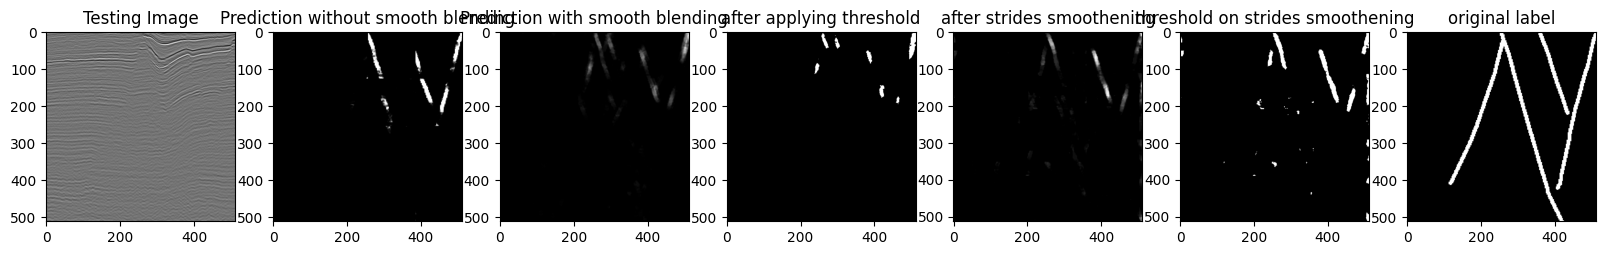

In [148]:
plt.figure(figsize=(20, 10))
plt.subplot(171)
plt.title('Testing Image')
plt.imshow(x_val[i], cmap='gray')
plt.subplot(172)
plt.title('Prediction without smooth blending')
plt.imshow(processed_prediction,"gray")
plt.subplot(173)
plt.title('Prediction with smooth blending')
plt.imshow(predictions_smooth,"gray")
plt.subplot(174)
plt.title("after applying threshold")
plt.imshow(final_prediction,"gray")
plt.subplot(175)
plt.title("after strides smoothening")
plt.imshow(padded_smooth_prediction,"gray")
plt.subplot(176)
plt.title("threshold on strides smoothening")
plt.imshow(final_strides_smoothening_prediction,"gray")
plt.subplot(177)
plt.title("original label")
plt.imshow(y_val[i],"gray")

plt.show()

Results

In [150]:
from sklearn.metrics import confusion_matrix  
import numpy as np

def compute_iou(y_pred, y_true):
 # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    FDA = intersection / ground_truth_set.astype(np.float32)
    return (np.mean(IoU),np.mean(FDA))

def batch_iou_and_fda(y_batch_pred, y_batch_true):
    length = len(y_batch_pred)
    total_iou = 0.0
    total_fda = 0.0
    for i in range(0, length):
        iou, fda = compute_iou(y_batch_pred[i], y_batch_true[i])
        total_iou+=iou
        total_fda+=fda
    return (total_iou/length, total_fda/length)


In [154]:
total_iou_in_bulk = 0
total_fda_in_bulk = 0
for i in range(0,len(x_val)):
    temp_smooth_y = smooth_prediction(model,100,x_val[i],x[0])
    threshold_pred = threshold_image(temp_smooth_y,0.074)
    iou_in_bulk, fda_in_bulk = compute_iou(threshold_pred,y_val[i])
    total_iou_in_bulk+=iou_in_bulk
    total_fda_in_bulk+=fda_in_bulk

print(total_iou_in_bulk/len(x_val), 'iou_batch')
print(total_fda_in_bulk/len(x_val), 'fda_batch')

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
7.0 no_of_parts
(768, 768, 1)
(512, 512, 1)
1/1 [==============================] - 0s 19ms/step


ValueError: Found input variables with inconsistent numbers of samples: [262144, 263169]

In [ ]:
threshold_prediction = threshold_image(processed_prediction,0.5)
iou, fda = compute_iou(threshold_prediction,y_val[i])
print(iou,fda)